In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import umap
from sklearn.decomposition import PCA

In [102]:
from matplotlib.colors import LinearSegmentedColormap
black = [i/255 for i in [38,38,38]]
blue = "#778DA9"
red = "#BA6668"
grad = ["#415A77","#778DA9","#E0E1DD","#DFD9DD","#BA6668","#823438"]
cmap_rb = LinearSegmentedColormap.from_list('custom',grad)

In [4]:
#emb.to_csv('/home/torii/LiveOrganismTranscriptomics/Script_for_LiveOrganismData/Data/.csv') 

In [7]:
# Load Data
emb = pd.read_csv("./path/to/Fate_andEmbryonicCellCode.csv",index_col=0)
gn_dict = {}
gn_dict_r = {}
with open("./path/to/GeneName.csv",mode="r") as gn:
    count=0
    for i in gn:
        #print(i.split(" ")[0], i.split(" ")[3])
        if count==0:
            count+=1
            continue
        if len(i.split(" ")) <= 3:
            gn_dict[i.split(" ")[0][1:-1]] = i.split(" ")[0][1:-1]
            gn_dict_r[i.split(" ")[0][1:-1]] = i.split(" ")[0][1:-1]
        else:
            gn_dict[i.split(" ")[0][1:-1]] = i.split(" ")[3][1:-1]
            gn_dict_r[i.split(" ")[3][1:-1]] = i.split(" ")[0][1:-1]   
    
nce = pd.read_csv("./path/to/RNA-seqData.csv",index_col=0)
nce.index = [gn_dict[i] for i in nce.index]
candidates = []
with open("./path/to/HighlyVariableGenes.txt", mode="r") as gg:
    for i in gg:
        candidates.append(i[:-1])
nce = nce.loc[candidates]
nce.columns = [i.replace("X","") for i in nce.columns]

In [63]:
# Integration of Velocity and Divergence to single embryo data
unity_alpha_dict = {}
for g in nce.index:
    unity_alpha_dict[g] = {}
    for emb_obj in emb.index:
        # Velocity
        alpha_P1 = (nce.loc[g,emb.loc[emb_obj,"P1"]]-nce.loc[g,emb.loc[emb_obj,"P0"]])/(nce.loc[g,emb.loc[emb_obj,"P0"]]+1)#2
        alpha_AB = (nce.loc[g,emb.loc[emb_obj,"AB"]]-nce.loc[g,emb.loc[emb_obj,"P0"]])/(nce.loc[g,emb.loc[emb_obj,"P0"]]+1)#2
        alpha_ABa = (nce.loc[g,emb.loc[emb_obj,"ABa"]]-nce.loc[g,emb.loc[emb_obj,"AB"]])/(nce.loc[g,emb.loc[emb_obj,"P0"]]+1)#2
        alpha_P2 = (nce.loc[g,emb.loc[emb_obj,"P2"]]-nce.loc[g,emb.loc[emb_obj,"P1"]])/(nce.loc[g,emb.loc[emb_obj,"P0"]]+1)#2
        # Divergence
        alpha_diff = alpha_AB-alpha_P1
        alpha_diff2 = alpha_ABa-alpha_P2
        unity_alpha_dict[g].update({"{}_alpha-P1".format(emb_obj):alpha_P1, 
                         "{}_alpha-AB".format(emb_obj):alpha_AB,
                         "{}_alpha-P2".format(emb_obj):alpha_P2, 
                         "{}_alpha-ABa".format(emb_obj):alpha_ABa,
                         "{}_alpha-diff".format(emb_obj):alpha_diff,
                         "{}_alpha-diff2".format(emb_obj):alpha_diff2,
                                   })
unity_alpha_df = pd.DataFrame(unity_alpha_dict)

new = []
for i in nce.columns:
    for j in emb.index:
        for k in emb.columns:
            if emb.loc[j,k] == i:
                new.append("{}_TP-{}".format(j,k))
nce.columns = new
cat_df = pd.concat([nce.T,unity_alpha_df], axis=0)

new_cat = {}
for e in emb.index:
    new_cat[e] = {}
    idxs = [i for i in cat_df.index if i.split("_")[0]==e]
    for idx in idxs:
        new_idxs=[idx.split("_")[1]+"_"+i for i in cat_df.columns]
        new_cat[e].update({i:j for i,j in zip(new_idxs, cat_df.loc[idx].values)})
new_cat = pd.DataFrame(new_cat)

<AxesSubplot:xlabel='x', ylabel='y'>

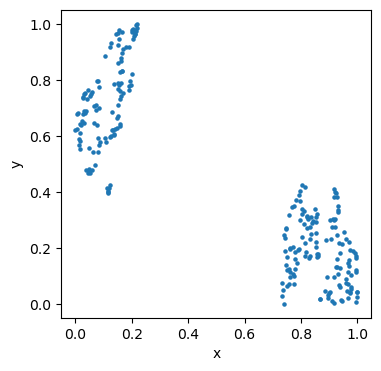

In [25]:
import umap
pca = PCA(n_components= 10, random_state=0) #3
pca_x = pca.fit_transform(cat_df.astype(float))
umap1 =  umap.UMAP(n_components=2, random_state=0, n_neighbors=10) #0,10
x_embedded = umap1.fit_transform(pca_x)
umap_df = pd.DataFrame(x_embedded, index=cat_df.index,columns=["x","y"])
umap_df.plot(x=0,y=1,kind="scatter",figsize=(4,4),s=5)

In [35]:
# Area Under Curve
umap_df["AlphaType"] = [i.split("_")[1] for i in umap_df.index]
umap_df["HorL"] = [emb.loc[i.split("_")[0],"HorL"] for i in umap_df.index]

from sklearn.tree import DecisionTreeClassifier
colors = {"alpha-diff2":"dimgray","alpha-diff":"gray","alpha-P1":"#7BA696","alpha-P2":"#286B59","alpha-AB":"#DE7766","alpha-ABa":"#A93F49",
         "TP-P0":"#CDCD7A","TP-P1":"#7BA697", "TP-P2":"#286B59", "TP-AB":"#DD7766","TP-ABa":"#A93F49"}

ln_accu = {}
for kk in colors.keys(): #P0,13, P1 9,  P2 7, AB 10, ABa 6 100% accuracy max_leaf_nodes
    ln_accu[kk] = {}
    for ln in range(2,16):
        X_train = umap_df[(umap_df["AlphaType"] == kk)][["x","y"]].values
        Y_train = umap_df[(umap_df["AlphaType"] == kk)][["HorL"]].values
        clf_model = DecisionTreeClassifier(max_leaf_nodes=ln)#max_depth=8)
        clf_model.fit(X_train, Y_train)
        accuracy = len(["O" for x,y in zip(Y_train, clf_model.predict(X_train)) if x==y])/len(Y_train)
        print(kk,len(["O" for x,y in zip(Y_train, clf_model.predict(X_train)) if x==y])/len(Y_train))
        ln_accu[kk][ln] = accuracy
        data = umap_df[(umap_df["AlphaType"] == kk)][["x","y"]].values
        min_x1, max_x1 = data[:, 0].min() - 1, data[:, 0].max() + 1
        min_x2, max_x2 = data[:, 1].min() - 1, data[:, 1].max() + 1
        xx1, xx2 = np.meshgrid(
            np.arange(min_x1, max_x1, 0.01), np.arange(min_x2, max_x2, 0.01))
        input_data = np.array([xx1.ravel(), xx2.ravel()]).T
        pred = clf_model.predict(input_data)
        pred = np.array([1 if i == "H" else 0 for i in pred])

alpha-diff2 0.9130434782608695
alpha-diff2 0.9130434782608695
alpha-diff2 0.9565217391304348
alpha-diff2 0.9565217391304348
alpha-diff2 1.0
alpha-diff2 1.0
alpha-diff2 1.0
alpha-diff2 1.0
alpha-diff2 1.0
alpha-diff2 1.0
alpha-diff2 1.0
alpha-diff2 1.0
alpha-diff2 1.0
alpha-diff2 1.0
alpha-diff 0.9565217391304348
alpha-diff 0.9565217391304348
alpha-diff 1.0
alpha-diff 1.0
alpha-diff 1.0
alpha-diff 1.0
alpha-diff 1.0
alpha-diff 1.0
alpha-diff 1.0
alpha-diff 1.0
alpha-diff 1.0
alpha-diff 1.0
alpha-diff 1.0
alpha-diff 1.0
alpha-P1 0.7391304347826086
alpha-P1 0.7391304347826086
alpha-P1 0.8260869565217391
alpha-P1 0.9130434782608695
alpha-P1 0.9130434782608695
alpha-P1 0.9565217391304348
alpha-P1 0.9565217391304348
alpha-P1 1.0
alpha-P1 1.0
alpha-P1 1.0
alpha-P1 1.0
alpha-P1 1.0
alpha-P1 1.0
alpha-P1 1.0
alpha-P2 0.7391304347826086
alpha-P2 0.782608695652174
alpha-P2 0.782608695652174
alpha-P2 0.8260869565217391
alpha-P2 0.8695652173913043
alpha-P2 0.8695652173913043
alpha-P2 0.913043478260

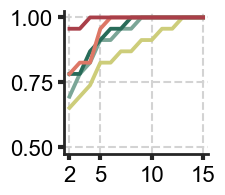

In [36]:
colors = {"alpha-diff2":"dimgray","alpha-diff":"gray","alpha-P1":"#7BA696","alpha-P2":"#286B59","alpha-AB":"#DE7766","alpha-ABa":"#A93F49",
         "TP-P0":"#CDCD7A","TP-P1":"#7BA697", "TP-P2":"#286B59", "TP-AB":"#DD7766","TP-ABa":"#A93F49"}

import matplotlib as mpl
font = {'family' : 'Arial','size': 16}
mpl.rc('font', **font)
fig,ax1 = plt.subplots(1, 1, figsize=(1*3/1.616,1*3/1.616))
ax1.set_axisbelow(True)
ax1.tick_params(labelbottom="on",bottom="on", labelleft="on",left="on", length=1.5*3,width=1*3, color=black)
for j in ["left","bottom"]:
    ax1.spines[j].set_color(black)
    ax1.spines[j].set_linewidth(1*2)
for j in ["top","right"]:
    ax1.spines[j].set_visible(False)
plt.xticks([2,5,10,15])
plt.xlim([1.5,15.5])
plt.yticks([0.5,0.75,1])
plt.ylim([0.475,1.025])
ln_df = pd.DataFrame(ln_accu)[['TP-P0', 'TP-P1', 'TP-P2', 'TP-AB', 'TP-ABa']]
ln_df.plot(ax=ax1,legend=False,color=[colors[i] for i in ln_df.columns],linewidth=2.75)
ax1.xaxis.grid(True, which='major', linestyle='--', color ="lightgray",linewidth=0.5*3)
ax1.yaxis.grid(True, which='major', linestyle='--', color ="lightgray",linewidth=0.5*3)
plt.show()

In [ ]:
# Comparison of Fate prediction acuuracy with orginal and shffled datasets

In [ ]:
# Original single embryo data
from sklearn.ensemble import RandomForestClassifier
import random
from sklearn.datasets import make_classification

states_list = ["TP-P0","TP-AB","TP-P1","TP-ABa","TP-P2"]
Ex_diff_list = ["alpha-diff","alpha-diff2"]
In_diff_list = ["alpha-P1","alpha-P2","alpha-AB","alpha-ABa"]
types = {"State":states_list, "Ex":Ex_diff_list,"In":In_diff_list}
obj_genes = new_cat.index[:-1]
embs = {i:j for i,j in zip(emb.index,emb["HorL"].values)}
accuracy_group_orginal = {}
num_L = 3
num_H = 3
for tp, tps in types.items():
    Lethals = list(emb[emb["HorL"] == "L"].index)
    Hatches = list(emb[emb["HorL"] == "H"].index)
    HorL = {}
    for e in embs.keys():
        if e in Lethals:
            HorL[e] = "L"
        else:
            HorL[e] = "H"
    acuuracy = []
    for tn in range(50):
        test_id = random.sample(Lethals,num_L)+random.sample(Hatches,num_H)
        train_id = [i for i in emb.index if i not in test_id]
        clf = RandomForestClassifier(max_depth=4, random_state=0,n_estimators=300)
        train_X = new_cat.loc[[i for i in new_cat.index if i.split("_")[0] in tps], train_id].T
        train_y = [HorL[i] for i in train_id]
        clf.fit(train_X, train_y)
        test_X = new_cat.loc[[i for i in new_cat.index if i.split("_")[0] in tps], test_id].T
        test_y = [HorL[i] for i in test_id]
        predict_y = clf.predict(test_X)
        acuuracy.append(len([i for i in range(num_L+num_H) if predict_y[i]==test_y[i]])/(num_L+num_H)*100)
        #print(tp,acuuracy[-1])
    else:
        accuracy_group_orginal[tp] = acuuracy

In [ ]:
# Shuffling single embryo data within the same fates

from sklearn.ensemble import RandomForestClassifier
import random
from sklearn.datasets import make_classification
states_list = ["TP-P0","TP-AB","TP-P1","TP-ABa","TP-P2"]
Ex_diff_list = ["alpha-diff","alpha-diff2"]
In_diff_list = ["alpha-P1","alpha-P2","alpha-AB","alpha-ABa"]
types = {"State":states_list, "Ex":Ex_diff_list,"In":In_diff_list}
accu_dict_shuffle_within_types = {}
for Cv_n in range(50):
    nce_random = nce.copy()
    L_emb = list(emb[emb["HorL"]=="L"].index)
    H_emb = list(emb[emb["HorL"]=="H"].index)
    random_pair = {}
    for name in ["P0","P1","P2","AB","ABa"]:
        L_emb_col = [i+"_TP-"+name for i in L_emb]
        H_emb_col = [i+"_TP-"+name for i in H_emb]
        L_emb_random = random.sample(list(L_emb_col),len(L_emb_col))
        H_emb_random = random.sample(list(H_emb_col),len(H_emb_col))
        for i,j in zip(L_emb_col+H_emb_col, L_emb_random+H_emb_random):
            random_pair[i] = j
    else:
        nce_random.columns = [random_pair[k] for k in nce_random.columns]

    unity_alpha_dict = {}
    for g in nce_random.index:
        unity_alpha_dict[g] = {}
        for emb_obj in emb.index:
            alpha_P1 = nce_random.loc[g,emb_obj+"_TP-P1"]/(nce_random.loc[g,emb_obj+"_TP-P0"]+1)#2
            alpha_AB = nce_random.loc[g,emb_obj+"_TP-AB"]/(nce_random.loc[g,emb_obj+"_TP-P0"]+1)#2
            alpha_ABa = nce_random.loc[g,emb_obj+"_TP-ABa"]/(nce_random.loc[g,emb_obj+"_TP-AB"]+1)#2
            alpha_P2 = nce_random.loc[g,emb_obj+"_TP-P2"]/(nce_random.loc[g,emb_obj+"_TP-P1"]+1)#2
            alpha_diff = alpha_AB-alpha_P1
            alpha_diff2 = alpha_ABa-alpha_P2
            #alpha_unity = (alpha_AB-alpha_P1)/(abs(alpha_AB)+abs(alpha_P1))
            unity_alpha_dict[g].update({"{}_alpha-P1".format(emb_obj):alpha_P1, 
                             "{}_alpha-AB".format(emb_obj):alpha_AB,
                             "{}_alpha-P2".format(emb_obj):alpha_P2, 
                             "{}_alpha-ABa".format(emb_obj):alpha_ABa,
                             "{}_alpha-diff".format(emb_obj):alpha_diff,
                             "{}_alpha-diff2".format(emb_obj):alpha_diff2,
                                       })
    unity_alpha_df = pd.DataFrame(unity_alpha_dict)
    cat_random = pd.concat([nce_random, unity_alpha_df.T],axis=1).T
    new_cat_r = {}
    for e in emb.index:
        new_cat_r[e] = {}
        idxs = [i for i in cat_random.index if i.split("_")[0]==e]
        for idx in idxs:
            new_idxs=[idx.split("_")[1]+"_"+i for i in cat_random.columns]
            new_cat_r[e].update({i:j for i,j in zip(new_idxs, cat_random.loc[idx].values)})
    cat_random = pd.DataFrame(new_cat_r).T
    embs = {i:j for i,j in zip(emb.index,emb["HorL"].values)}
    num_L = 3
    num_H = 3
    for TP,tp in types.items():
        Lethals = list(emb[emb["HorL"] == "L"].index)
        Hatches = list(emb[emb["HorL"] == "H"].index)
        HorL = {}
        for e in embs.keys():
            if e in Lethals:
                HorL[e] = "L"
            else:
                HorL[e] = "H"
        acuuracy = []
        for tn in range(50):
            test_id = random.sample(Lethals,num_L)+random.sample(Hatches,num_H)
            train_id = [i for i in emb.index if i not in test_id]
            #train_X_id = [i for i in cat_random.columns if (i.split("_")[0] in train_id)&(i.split("_")[1] in tp)]
            #test_X_id = [i for i in cat_random.columns if (i.split("_")[0] in test_id)&(i.split("_")[1] in tp)]

            train_X_id = [j for j in cat_random.columns if (j.split("_")[0] in tp)]
            test_X_id = [j for j in cat_random.columns if (j.split("_")[0] in tp)]
            clf = RandomForestClassifier(max_depth=4, random_state=0,n_estimators=300,n_jobs=-1)
            train_X = cat_random.loc[train_id,train_X_id]
            train_y = [HorL[i] for i in train_id]
            clf.fit(train_X, train_y)
            #FeatureImp = pd.DataFrame(clf.feature_importances_, index=embs_df.index, columns=["gini"])
            #FeatureImp.sort_values(by="gini",ascending=False,inplace=True)
            test_X = cat_random.loc[test_id,test_X_id]
            test_y = [HorL[i] for i in test_id]
            predict_y = clf.predict(test_X)
            acuuracy.append(len([i for i in range(num_L+num_H) if predict_y[i]==test_y[i]])/(num_L+num_H)*100)
        else:
            accu_dict_shuffle_within_types[str(Cv_n)+"_"+TP]  = acuuracy
            #print(tp,np.mean(acuuracy), np.std(acuuracy))

In [ ]:
# Shuffling single embryo data

from sklearn.ensemble import RandomForestClassifier
import random
from sklearn.datasets import make_classification
states_list = ["TP-P0","TP-AB","TP-P1","TP-ABa","TP-P2"]
Ex_diff_list = ["alpha-diff","alpha-diff2"]
In_diff_list = ["alpha-P1","alpha-P2","alpha-AB","alpha-ABa"]
types = {"State":states_list, "Ex":Ex_diff_list,"In":In_diff_list}
accu_dict_shuffle_whole_types = {}
for Cv_n in range(50):
    nce_random = nce.copy()
    W_emb = list(emb.index)
    random_pair = {}
    for name in ["P0","P1","P2","AB","ABa"]:
        W_emb_col = [i+"_TP-"+name for i in W_emb]
        W_emb_random = random.sample(list(W_emb_col),len(W_emb_col))
        for i,j in zip(W_emb_col, W_emb_random):
            random_pair[i] = j
    else:
        nce_random.columns = [random_pair[k] for k in nce_random.columns]

    unity_alpha_dict = {}
    for g in nce_random.index:
        unity_alpha_dict[g] = {}
        for emb_obj in emb.index:
            alpha_P1 = nce_random.loc[g,emb_obj+"_TP-P1"]/(nce_random.loc[g,emb_obj+"_TP-P0"]+1)#2
            alpha_AB = nce_random.loc[g,emb_obj+"_TP-AB"]/(nce_random.loc[g,emb_obj+"_TP-P0"]+1)#2
            alpha_ABa = nce_random.loc[g,emb_obj+"_TP-ABa"]/(nce_random.loc[g,emb_obj+"_TP-AB"]+1)#2
            alpha_P2 = nce_random.loc[g,emb_obj+"_TP-P2"]/(nce_random.loc[g,emb_obj+"_TP-P1"]+1)#2
            alpha_diff = alpha_AB-alpha_P1
            alpha_diff2 = alpha_ABa-alpha_P2
            #alpha_unity = (alpha_AB-alpha_P1)/(abs(alpha_AB)+abs(alpha_P1))
            unity_alpha_dict[g].update({"{}_alpha-P1".format(emb_obj):alpha_P1, 
                             "{}_alpha-AB".format(emb_obj):alpha_AB,
                             "{}_alpha-P2".format(emb_obj):alpha_P2, 
                             "{}_alpha-ABa".format(emb_obj):alpha_ABa,
                             "{}_alpha-diff".format(emb_obj):alpha_diff,
                             "{}_alpha-diff2".format(emb_obj):alpha_diff2,
                                       })
    unity_alpha_df = pd.DataFrame(unity_alpha_dict)
    cat_random = pd.concat([nce_random, unity_alpha_df.T],axis=1).T
    new_cat_r = {}
    for e in emb.index:
        new_cat_r[e] = {}
        idxs = [i for i in cat_random.index if i.split("_")[0]==e]
        for idx in idxs:
            new_idxs=[idx.split("_")[1]+"_"+i for i in cat_random.columns]
            new_cat_r[e].update({i:j for i,j in zip(new_idxs, cat_random.loc[idx].values)})
    cat_random = pd.DataFrame(new_cat_r).T
    embs = {i:j for i,j in zip(emb.index,emb["HorL"].values)}
    num_L = 3
    num_H = 3
    for TP,tp in types.items():
        Lethals = list(emb[emb["HorL"] == "L"].index)
        Hatches = list(emb[emb["HorL"] == "H"].index)
        HorL = {}
        for e in embs.keys():
            if e in Lethals:
                HorL[e] = "L"
            else:
                HorL[e] = "H"
        acuuracy = []
        for tn in range(50):
            test_id = random.sample(Lethals,num_L)+random.sample(Hatches,num_H)
            train_id = [i for i in emb.index if i not in test_id]
            #train_X_id = [i for i in cat_random.columns if (i.split("_")[0] in train_id)&(i.split("_")[1] in tp)]
            #test_X_id = [i for i in cat_random.columns if (i.split("_")[0] in test_id)&(i.split("_")[1] in tp)]

            train_X_id = [j for j in cat_random.columns if (j.split("_")[0] in tp)]
            test_X_id = [j for j in cat_random.columns if (j.split("_")[0] in tp)]
            clf = RandomForestClassifier(max_depth=4, random_state=0,n_estimators=100,n_jobs=-1)
            train_X = cat_random.loc[train_id,train_X_id]
            train_y = [HorL[i] for i in train_id]
            clf.fit(train_X, train_y)
            #FeatureImp = pd.DataFrame(clf.feature_importances_, index=embs_df.index, columns=["gini"])
            #FeatureImp.sort_values(by="gini",ascending=False,inplace=True)
            test_X = cat_random.loc[test_id,test_X_id]
            test_y = [HorL[i] for i in test_id]
            predict_y = clf.predict(test_X)
            acuuracy.append(len([i for i in range(num_L+num_H) if predict_y[i]==test_y[i]])/(num_L+num_H)*100)
        else:
            accu_dict_shuffle_whole_types[str(Cv_n)+"_"+TP]  = acuuracy
            #print(tp,np.mean(acuuracy), np.std(acuuracy))

In [ ]:
# Exploration of determinants

573


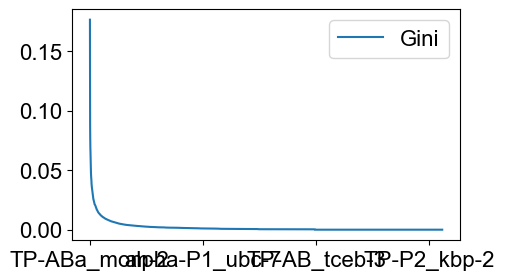

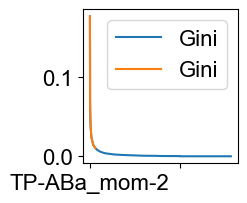

In [64]:
from sklearn.ensemble import RandomForestClassifier
from kneed import KneeLocator
from sklearn.datasets import make_classification

# Classification analysis by RF
FI = np.zeros(len(new_cat.index))
FI_dict = {}
X_train = new_cat.T
y_train = [emb.loc[i,"HorL"] for i in new_cat.columns]
for i in range(0,30):
    clf = RandomForestClassifier(max_depth=4, random_state=i,n_estimators=500,n_jobs=-1)
    clf.fit(X_train, y_train)
    FI += clf.feature_importances_
FeatureImp_df = pd.DataFrame(FI,index = new_cat.index,columns=["Gini"]).sort_values("Gini",ascending=False)
FeatureImp_df.plot(figsize=(5,3))

# Extraction of Determinatns
kn = KneeLocator(x=[i for i in range(len(FeatureImp_df.index))], 
             y=list(FeatureImp_df["Gini"].values), 
             curve='convex', 
             direction='decreasing',
                S=3.4)
fig,ax = plt.subplots(figsize=(2,2))
FeatureImp_df.plot(ax=ax)
#FeatureImp_df.iloc[:1300].plot(ax=ax)
FeatureImp_df.iloc[:kn.knee].plot(ax=ax)
print(kn.knee)
HighGiniGeneSet = FeatureImp_df.iloc[:kn.knee].index
FI_rank = FeatureImp_df.copy()
FI_rank.index = [n for n,i in enumerate(FI_rank.index)]

In [ ]:
# Regression from P0 determinants to determinatns of 2-cell stage divergence
from sklearn.ensemble import RandomForestRegressor as RFR
from scipy import stats
new_cat_G = new_cat.T[HighGiniGeneSet]
states_list = ["TP-P0","TP-AB","TP-P1","TP-ABa","TP-P2","alpha-diff","alpha-diff2","alpha-P1","alpha-P2","alpha-AB","alpha-ABa"]
embs = {i:j for i,j in zip(emb.index,emb["HorL"].values)}
diff_genes = [i for i in HighGiniGeneSet if i.split("_")[0]=="alpha-diff"]
P0_genes = [i for i in HighGiniGeneSet if i.split("_")[0]=="TP-P0"]
num_L = 3
num_H = 3
accu_dict_orig = {}
for tp in range(1):
    Lethals = list(emb[emb["HorL"] == "L"].index)
    Hatches = list(emb[emb["HorL"] == "H"].index)
    HorL = {}
    for e in embs.keys():
        if e in Lethals:
            HorL[e] = "L"
        else:
            HorL[e] = "H"
    train_id = list(emb.index)
    train_X_P0 = new_cat_G.loc[train_id,P0_genes]
    predicted_diff = []
    fi = {}
    for d in diff_genes:
        train_y_diff = stats.zscore(new_cat_G.loc[train_id,d].T)
        rg = RFR(n_jobs=-1, random_state=0,n_estimators=100,max_depth=4) 
        rg.fit(train_X_P0, train_y_diff)
        fi[d] = rg.feature_importances_
FI_df = pd.DataFrame(fi,index = P0_genes)
FI_df.sum(axis=1).sort_values(ascending=False)

In [99]:
#Gene Correlaion Network
states_list = ["TP-P0","TP-AB","TP-P1","TP-ABa","TP-P2","alpha-diff","alpha-diff2","alpha-P1","alpha-P2","alpha-AB","alpha-ABa"]
import networkx as nx
corrs = {}
corrs_list=[]
cent_fzy = {}
cent_noca = {}
for th2 in [0.7]:
    pos_th = th2
    neg_th = -1*th2
    Net_keys = []
    for i in states_list:
        for j in states_list:
            if i==j:continue
            if (i+"_"+j in Net_keys)|(j+"_"+i in Net_keys): continue
            else:Net_keys.append(i+"_"+j)

    pos_pairs = []
    neg_pairs = []
    for k in Net_keys:
        reg_key = k.split("_")[0]
        rsp_key = k.split("_")[1]
        regset = [i for i in HighGiniGeneSet if i.split("_")[0] == reg_key]
        rspset = [i for i in HighGiniGeneSet if i.split("_")[0] == rsp_key]
        allset = regset + rspset
        high_corr = new_cat.T[regset+rspset].corr(method="spearman").values #spearman
        high_corr = pd.DataFrame(np.triu(high_corr, k=1), 
                                    index = allset, columns=allset)
        corrs_list += list(high_corr.melt()["value"].values)
        pos_pair = list(high_corr[high_corr>pos_th].stack().index) 
        neg_pair = list(high_corr[high_corr<neg_th].stack().index)
        pos_pairs += pos_pair
        neg_pairs += neg_pair

    comb = []
    all_genes = []
    for p in pos_pairs+neg_pairs:
        s,e = p
        if s==e:continue
        all_genes += [s,e]
        if (e=="P0"):
            comb.append([e,s])
        elif (s=="P2"):
            comb.append([e,s])
        elif (s=="ABa"):
            comb.append([e,s])
        else:
            comb.append([s,e])
    all_genes = list(set(all_genes))

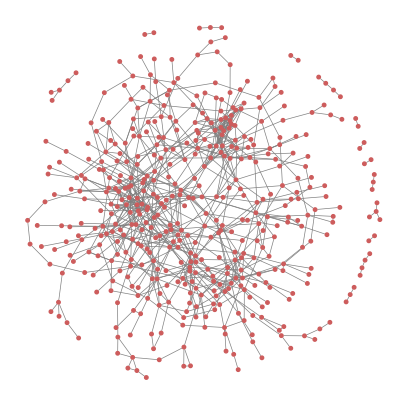

In [101]:
# Draw network
import networkx as nx
import igraph as ig
G=nx.Graph ()
reg_l = []
rsp_l = []
for cb in comb:
    reg, rsp = cb#.split(">")
    reg_l.append(reg)
    rsp_l.append(rsp)
    G.add_edge(reg, rsp, weight = 1)
reg_l = list(set(reg_l))
rsp_l = list(set(rsp_l))

edgelist=[list(i) for i in G.edges]
weights = [1 if u.split("_")[0]== v.split("_")[0] else 1 for u,v in G.edges]

count = 0
count_dict = {}
count_dict_r = {}
for i in edgelist:
    if i[0] not in count_dict.keys():
        count_dict[i[0]] = count
        count_dict_r[count] = i[0]
        count+=1
    if i[1] not in count_dict.keys():
        count_dict[i[1]] = count
        count_dict_r[count] = i[1]
        count+=1
Num_edgelist = [[count_dict[i[0]], count_dict[i[1]]] for i in edgelist]
g = ig.Graph(edges = Num_edgelist)
g.es['weight'] = weights
g.vs["name"] = [count_dict_r[i] for i in range(len(count_dict_r.keys()))]
kamada_kawai_positions = g.layout_kamada_kawai()
layout = g.layout_fruchterman_reingold(seed=kamada_kawai_positions,weights=weights,niter = 1000)#750
fig, ax = plt.subplots(figsize=(5,5))
ig.plot(g, target=ax,layout=layout,        
        vertex_size=2.5,
        vertex_color="indianred",
        edge_width=0.5,
        edge_color="gray",
       )
plt.axis("off")
L=pd.DataFrame(layout._coords,index=g.vs["name"],columns=["x","y"])
pos_L = {i:[j["x"], j["y"]] for i,j in L.iterrows()}

In [97]:
# Evaluate closeness centlarity of fzy-1 expression in P0
states_list = ["TP-P0","TP-AB","TP-P1","TP-ABa","TP-P2","alpha-diff","alpha-diff2","alpha-P1","alpha-P2","alpha-AB","alpha-ABa"]
import networkx as nx
corrs = {}
corrs_list=[]
cent_fzy = {}
cent_noca = {}
for th2 in np.linspace(0.4,0.7,16):
    pos_th = th2
    neg_th = -1*th2

    Net_keys = []
    for i in states_list:
        for j in states_list:
            if i==j:continue
            if (i+"_"+j in Net_keys)|(j+"_"+i in Net_keys): continue
            else:Net_keys.append(i+"_"+j)

    pos_pairs = []
    neg_pairs = []
    for k in Net_keys:
        reg_key = k.split("_")[0]
        rsp_key = k.split("_")[1]
        regset = [i for i in HighGiniGeneSet if i.split("_")[0] == reg_key]
        rspset = [i for i in HighGiniGeneSet if i.split("_")[0] == rsp_key]
        allset = regset + rspset
        high_corr = new_cat.T[regset+rspset].corr(method="spearman").values
        high_corr = pd.DataFrame(np.triu(high_corr, k=1), 
                                    index = allset, columns=allset)
        corrs_list += list(high_corr.melt()["value"].values)
        pos_pair = list(high_corr[high_corr>pos_th].stack().index) 
        neg_pair = list(high_corr[high_corr<neg_th].stack().index)
        pos_pairs += pos_pair
        neg_pairs += neg_pair

    comb = []
    all_genes = []
    for p in pos_pairs+neg_pairs:
        s,e = p
        if s==e:continue
        all_genes += [s,e]
        if (e=="P0"):
            comb.append([e,s])
        elif (s=="P2"):
            comb.append([e,s])
        elif (s=="ABa"):
            comb.append([e,s])
        else:
            comb.append([s,e])
    all_genes = list(set(all_genes))

    G=nx.Graph()
    reg_l = []
    rsp_l = []
    for cb in comb:
        reg, rsp = cb
        reg_l.append(reg)
        rsp_l.append(rsp)
        G.add_edge(reg, rsp, weight = 1)
    cent_df = pd.DataFrame(nx.closeness_centrality(G),index=["Cent"]).T.sort_values("Cent",ascending=False)
    print(th2, cent_df.index.get_loc("TP-P0_fzy-1"))

0.4 0
0.42000000000000004 0
0.44 0
0.46 0
0.48 0
0.5 0
0.52 1
0.54 0
0.56 0
0.58 0
0.6 1
0.62 2
0.64 1
0.6599999999999999 0
0.6799999999999999 0
0.7 0


In [104]:
colors = {"alpha-diff2":"#BA6489","alpha-diff":"#BA6489","alpha-P1":"#859BA7","alpha-P2":"#859BA7","alpha-AB":"#859BA7","alpha-ABa":"#859BA7",
         "P0":"#C6A2C6","P1":"#859AA7", "P2":"#5F6B7F", "AB":"#BA6388","ABa":"#8E4E66"}


4428
3964
3736
4812
5704


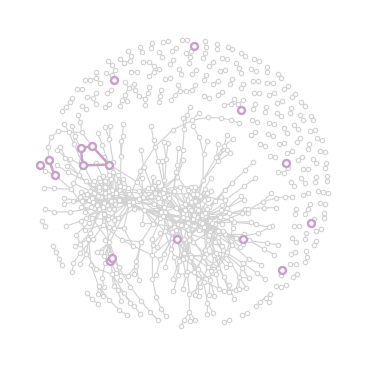

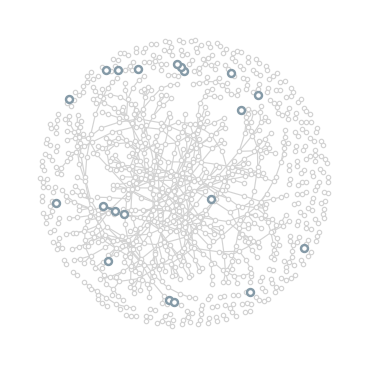

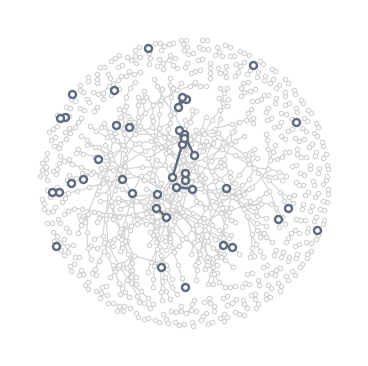

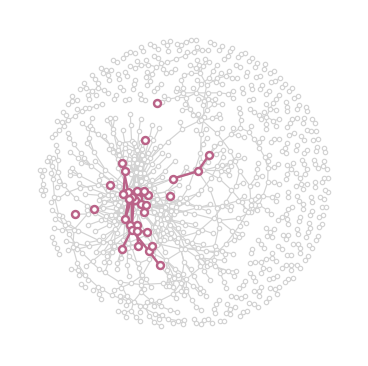

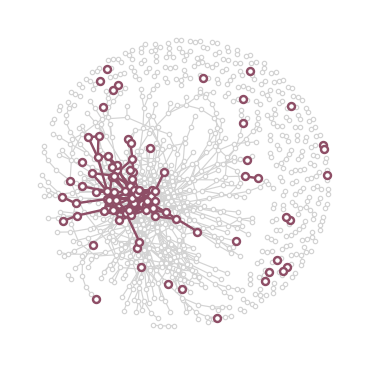

In [105]:
# Correlation gene network in each cell type
th_dict = {"P0":0.74213 ,"P1":0.704,"P2":0.702,"AB":0.709,"ABa":0.7}
iter_dict = {"P0":400 ,"P1":120,"P2":100,"AB":400,"ABa":400}
for n,ct in enumerate(["P0","P1","P2","AB","ABa"]):
    th2 = th_dict[ct]  #P = 5.000000616761418e-05
    #th2 = 0.5256198 #P = 0.005000007013094509
    pos_th = th2
    neg_th = -1*th2

    regset = [i for i in new_cat.index if i.split("_")[0]=="TP-"+ct]
    rspset = [i for i in new_cat.index if i.split("_")[0]=="TP-"+ct]
    allset = regset + rspset
    high_corr = new_cat.T[regset+rspset].corr(method="spearman").values #spearman
    high_corr = pd.DataFrame(np.triu(high_corr, k=1), 
                                index = allset, columns=allset)
    pos_pair = list(high_corr[high_corr>pos_th].stack().index) 
    neg_pair = list(high_corr[high_corr<neg_th].stack().index)

    comb = []
    all_genes = []
    for p in pos_pair+neg_pair:
        s,e = p
        if s==e:continue
        all_genes += [s,e]
        if (e=="P0"):
            comb.append([e,s])
        elif (s=="P2"):
            comb.append([e,s])
        elif (s=="ABa"):
            comb.append([e,s])
        else:
            comb.append([s,e])
    all_genes = list(set(all_genes))
    print(len(comb))



    G=nx.Graph ()
    reg_l = []
    rsp_l = []
    for cb in comb:
        reg, rsp = cb#.split(">")
        reg_l.append(reg)
        rsp_l.append(rsp)
        G.add_edge(reg, rsp, weight = 1)
    reg_l = list(set(reg_l))
    rsp_l = list(set(rsp_l))

    edgelist=[list(i) for i in G.edges]
    weights = [1 if u.split("_")[0]== v.split("_")[0] else 1 for u,v in G.edges]
    count = 0
    count_dict = {}
    count_dict_r = {}
    for i in edgelist:
        if i[0] not in count_dict.keys():
            count_dict[i[0]] = count
            count_dict_r[count] = i[0]
            count+=1
        if i[1] not in count_dict.keys():
            count_dict[i[1]] = count
            count_dict_r[count] = i[1]
            count+=1
    Num_edgelist = [[count_dict[i[0]], count_dict[i[1]]] for i in edgelist]
    g = ig.Graph(edges = Num_edgelist)
    g.es['weight'] = weights
    g.vs["name"] = [count_dict_r[i] for i in range(len(count_dict_r.keys()))]
    kamada_kawai_positions = g.layout_kamada_kawai()
    layout = g.layout_fruchterman_reingold(seed=kamada_kawai_positions,weights=weights,niter = iter_dict[ct])
    L=pd.DataFrame(layout._coords,index=g.vs["name"],columns=["x","y"])
    pos_L = {i:[j["x"], j["y"]] for i,j in L.iterrows()}

    fig, ax = plt.subplots(1, 1, figsize=(4.5*1,4.5*1))
    obj = [i for i in G.nodes if i in HighGiniGeneSet]
    not_obj = [i for i in G.nodes if i not in HighGiniGeneSet]
    obj_edges =  [i for i in G.edges() if (i[0] in HighGiniGeneSet)&(i[1] in HighGiniGeneSet)]
    not_obj_edges = [i for i in G.edges() if i not in obj_edges]
    nodes_not_obj_nx = nx.draw_networkx_edges(G,pos_L,edge_color="lightgray",width=0.85,alpha=1,edgelist = not_obj_edges)
    nodes_not_obj_nx.set_zorder(1)
    edges_not_obj_nx = nx.draw_networkx_nodes(G, pos_L, node_color = "w", node_size = 10, alpha = 1,
                           linewidths=0.85, edgecolors= "lightgray",
                           nodelist = not_obj)
    edges_not_obj_nx.set_zorder(1)
    
    nodes_obj_nx = nx.draw_networkx_nodes(G, pos_L, node_color = "w", node_size = 25, alpha = 1,
                           linewidths=1.75, edgecolors= colors[ct],
                           nodelist = obj)
    nodes_obj_nx.set_zorder(3)
    edges_obj_nx = nx.draw_networkx_edges(G,pos_L,edge_color=colors[ct],width=1.75,alpha=1,edgelist = obj_edges)
    edges_obj_nx.set_zorder(2)
    #nx.draw_networkx_labels(G, pos_L,font_size=7, font_color=black, font_family='Arial',ax=ax)
    plt.axis("off")